In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
(train_x, _), (test_x, _) = keras.datasets.mnist.load_data()

In [3]:
train_x = np.vstack([train_x, test_x])

In [4]:
print(f'Images shape: {train_x.shape}')

Images shape: (70000, 28, 28)


In [5]:
train_x = train_x.astype(np.float32) / 127.5 - 1

In [6]:
generator = keras.Sequential([
    keras.layers.Dense(250, input_shape=(100,)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1000),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(784, activation='tanh'),
    keras.layers.Reshape((28, 28))])
generator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               25250     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 250)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               125500    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              501000    
__________

In [7]:
discriminator = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(250),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')])
discriminator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
__________

In [8]:
discriminator.trainable = False
inputs = keras.layers.Input(shape=(100,))
outputs = discriminator(generator(inputs))

combined = keras.Model(inputs=inputs, outputs=outputs)
combined.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28)            1443534   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 518001    
Total params: 1,961,535
Trainable params: 1,440,034
Non-trainable params: 521,501
_________________________________________________________________


In [9]:
def train(images, batch_size=32, epochs=1):
    batch_count = int(images.shape[0] / batch_size)
    
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        start_time = time.time()
        d_loss, g_loss = 0, 0
        for _ in range(batch_count):
            real_images = images[
                np.random.randint(0, images.shape[0], size=batch_size)]
            generated_images = generator.predict(
                np.random.normal(0, 1, size=(batch_size, 100)))

            x = np.vstack([real_images, generated_images])
            y = np.hstack([np.ones(batch_size), np.zeros(batch_size)])
            discriminator.trainable = True
            d_loss += discriminator.train_on_batch(x, y)
            
            x = np.random.normal(0, 1, size=(batch_size, 100))
            y = np.ones(batch_size)
            discriminator.trainable = False
            g_loss += combined.train_on_batch(x, y)

        duration = time.time() - start_time
        d_loss /= batch_count
        g_loss /= batch_count
        print(f' - {duration:.0f}s - d_loss: {d_loss:.4f} - g_loss: {g_loss:.4f}')
        
        if epoch == 1 or epoch % 20 == 0:
            generated_images = generator.predict(
                np.random.normal(0, 1, size=(64, 100)))
            plt.figure(figsize=(16, 16))
            for i in range(64):
                plt.subplot(8, 8, i + 1)
                plt.imshow(generated_images[i], cmap=plt.cm.binary)
                plt.xticks([])
                plt.yticks([])
            plt.show()

Epoch 1/400
 - 47s - d_loss: 0.0430 - g_loss: 13.8339


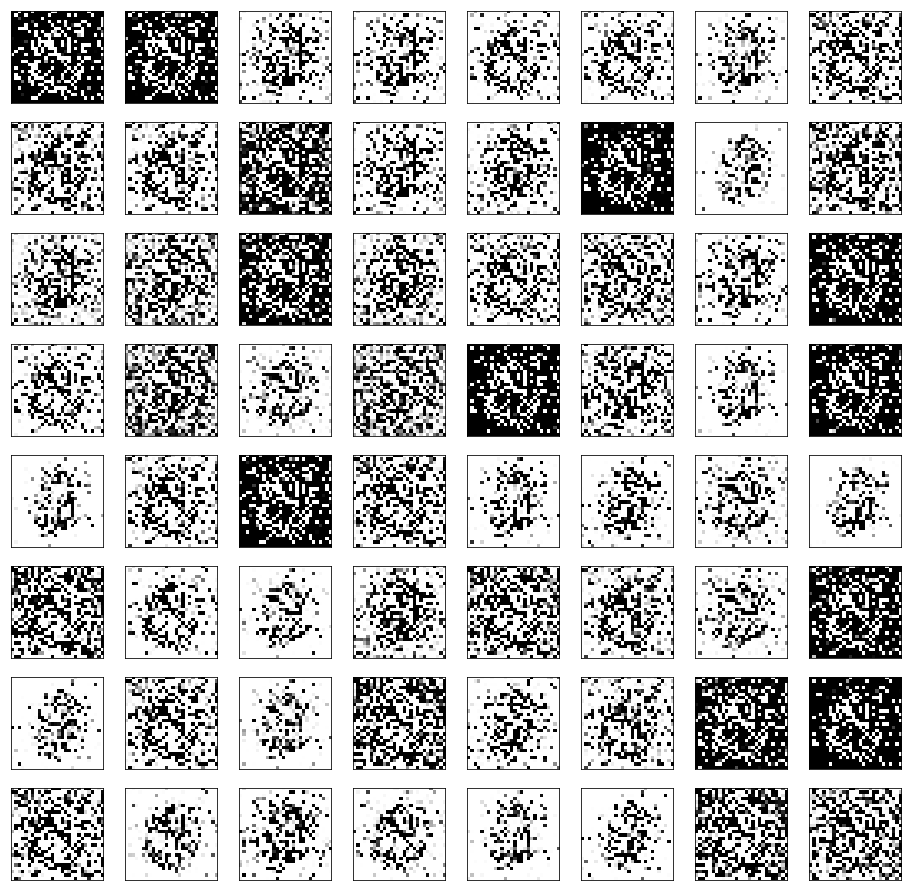

Epoch 2/400
 - 44s - d_loss: 0.0263 - g_loss: 13.9732
Epoch 3/400
 - 44s - d_loss: 0.0370 - g_loss: 12.8418
Epoch 4/400
 - 42s - d_loss: 0.0401 - g_loss: 11.6812
Epoch 5/400
 - 43s - d_loss: 0.0289 - g_loss: 12.3582
Epoch 6/400
 - 43s - d_loss: 0.0483 - g_loss: 11.5153
Epoch 7/400
 - 42s - d_loss: 0.0418 - g_loss: 11.3906
Epoch 8/400
 - 43s - d_loss: 0.0489 - g_loss: 10.6388
Epoch 9/400
 - 43s - d_loss: 0.0616 - g_loss: 10.0345
Epoch 10/400
 - 43s - d_loss: 0.0965 - g_loss: 8.6396
Epoch 11/400
 - 42s - d_loss: 0.1052 - g_loss: 8.0308
Epoch 12/400
 - 44s - d_loss: 0.1415 - g_loss: 7.3739
Epoch 13/400
 - 45s - d_loss: 0.1530 - g_loss: 7.1070
Epoch 14/400
 - 42s - d_loss: 0.1724 - g_loss: 6.4707
Epoch 15/400
 - 43s - d_loss: 0.1839 - g_loss: 6.4303
Epoch 16/400
 - 43s - d_loss: 0.2115 - g_loss: 5.7426
Epoch 17/400
 - 43s - d_loss: 0.2276 - g_loss: 5.7022
Epoch 18/400
 - 42s - d_loss: 0.2156 - g_loss: 5.5834
Epoch 19/400
 - 43s - d_loss: 0.2494 - g_loss: 5.5196
Epoch 20/400
 - 44s - d_loss

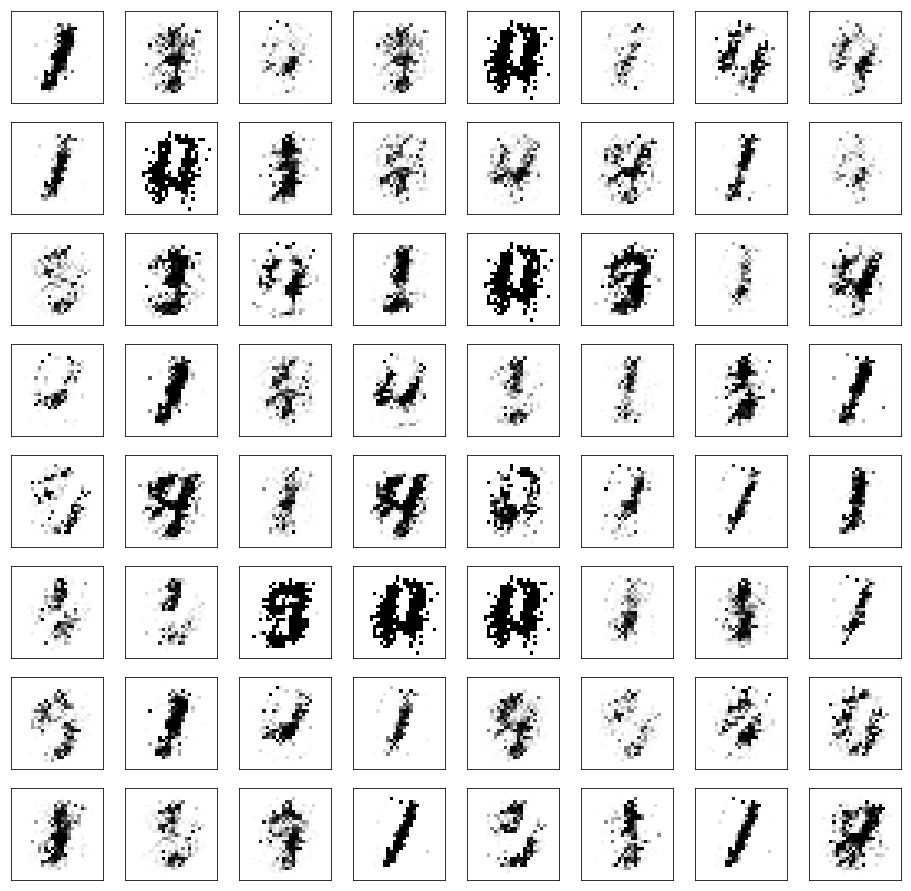

Epoch 21/400
 - 43s - d_loss: 0.2595 - g_loss: 5.5677
Epoch 22/400
 - 42s - d_loss: 0.2777 - g_loss: 5.1199
Epoch 23/400
 - 43s - d_loss: 0.2817 - g_loss: 5.2751
Epoch 24/400
 - 43s - d_loss: 0.2810 - g_loss: 5.2115
Epoch 25/400
 - 42s - d_loss: 0.3067 - g_loss: 5.1440
Epoch 26/400
 - 43s - d_loss: 0.2999 - g_loss: 5.0242
Epoch 27/400
 - 43s - d_loss: 0.3024 - g_loss: 4.8945
Epoch 28/400
 - 43s - d_loss: 0.3582 - g_loss: 4.4921
Epoch 29/400
 - 43s - d_loss: 0.3783 - g_loss: 4.0766
Epoch 30/400
 - 43s - d_loss: 0.4039 - g_loss: 3.7758
Epoch 31/400
 - 44s - d_loss: 0.4096 - g_loss: 3.9780
Epoch 32/400
 - 42s - d_loss: 0.3755 - g_loss: 4.3029
Epoch 33/400
 - 44s - d_loss: 0.3985 - g_loss: 4.0060
Epoch 34/400
 - 43s - d_loss: 0.3907 - g_loss: 4.1231
Epoch 35/400
 - 43s - d_loss: 0.3603 - g_loss: 4.6272
Epoch 36/400
 - 42s - d_loss: 0.3885 - g_loss: 4.4435
Epoch 37/400
 - 45s - d_loss: 0.4116 - g_loss: 4.2337
Epoch 38/400
 - 44s - d_loss: 0.4136 - g_loss: 4.0990
Epoch 39/400
 - 43s - d_loss

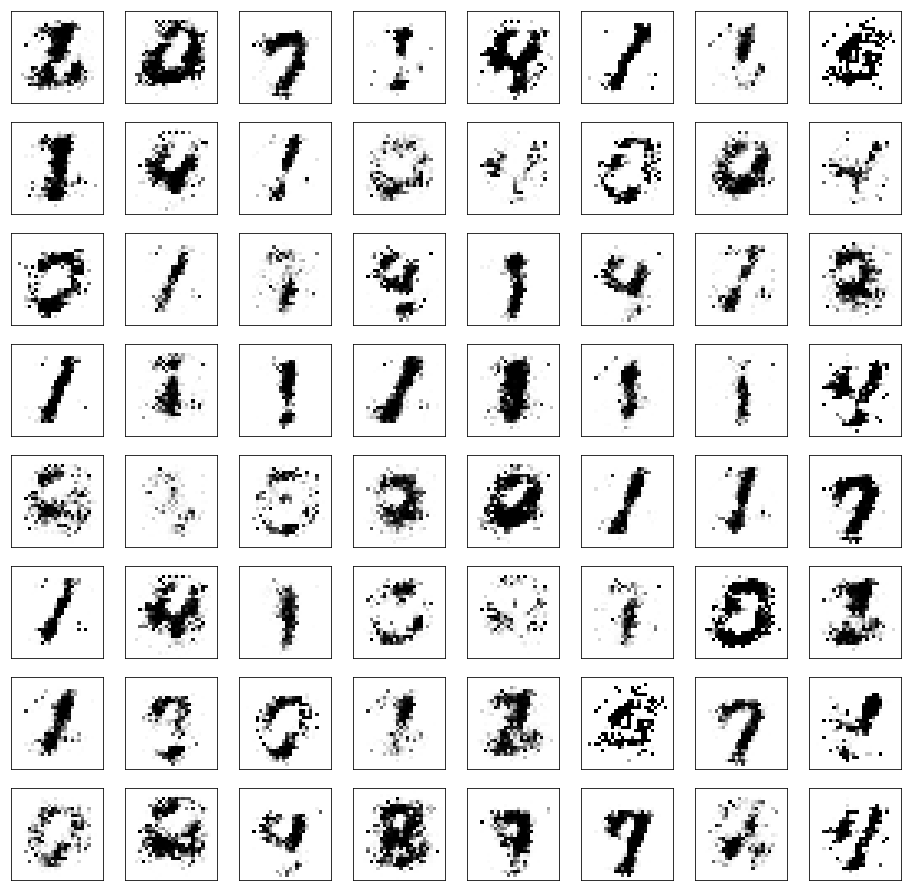

Epoch 41/400
 - 44s - d_loss: 0.4375 - g_loss: 3.5937
Epoch 42/400
 - 44s - d_loss: 0.4286 - g_loss: 3.9831
Epoch 43/400
 - 42s - d_loss: 0.4604 - g_loss: 3.7021
Epoch 44/400
 - 44s - d_loss: 0.4695 - g_loss: 3.3851
Epoch 45/400
 - 44s - d_loss: 0.4759 - g_loss: 3.4372
Epoch 46/400
 - 42s - d_loss: 0.4572 - g_loss: 3.8093
Epoch 47/400
 - 42s - d_loss: 0.4351 - g_loss: 4.1066
Epoch 48/400
 - 42s - d_loss: 0.4737 - g_loss: 3.4142
Epoch 49/400
 - 43s - d_loss: 0.4530 - g_loss: 3.5818
Epoch 50/400
 - 42s - d_loss: 0.4911 - g_loss: 3.4479
Epoch 51/400
 - 43s - d_loss: 0.4938 - g_loss: 3.2693
Epoch 52/400
 - 43s - d_loss: 0.5323 - g_loss: 3.1191
Epoch 53/400
 - 42s - d_loss: 0.5160 - g_loss: 2.9062
Epoch 54/400
 - 43s - d_loss: 0.5104 - g_loss: 3.4442
Epoch 55/400
 - 42s - d_loss: 0.5591 - g_loss: 2.5572
Epoch 56/400
 - 43s - d_loss: 0.5491 - g_loss: 2.6829
Epoch 57/400
 - 42s - d_loss: 0.5482 - g_loss: 2.8176
Epoch 58/400
 - 42s - d_loss: 0.5317 - g_loss: 3.0522
Epoch 59/400
 - 42s - d_loss

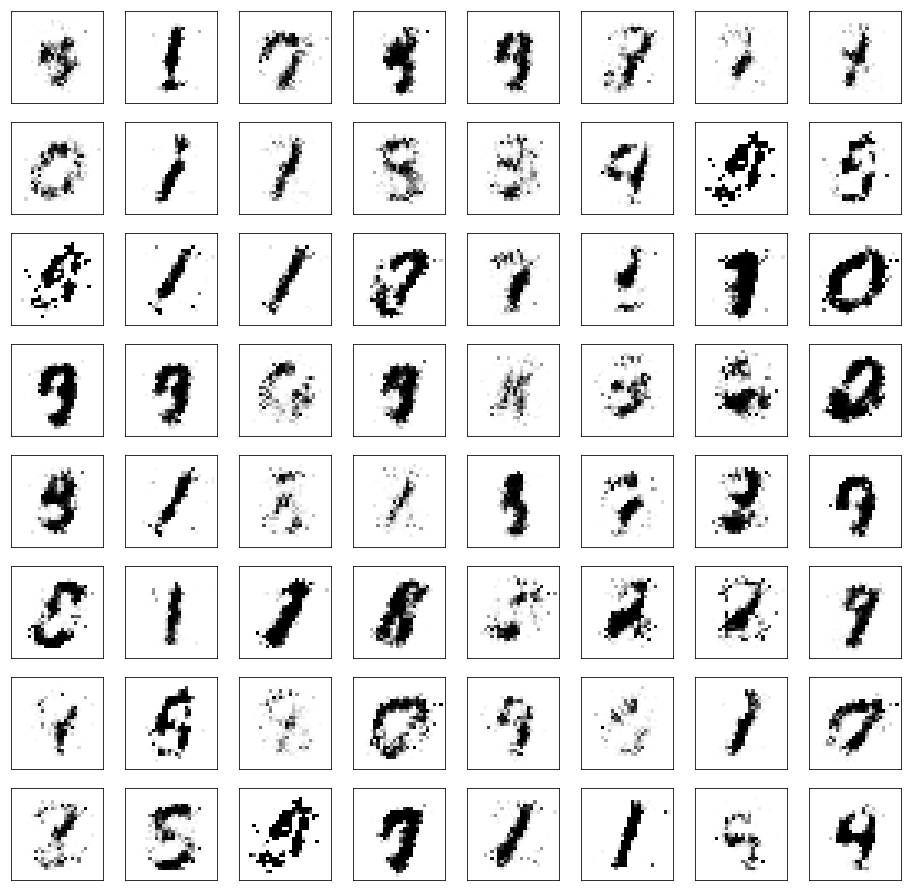

Epoch 61/400
 - 43s - d_loss: 0.5471 - g_loss: 2.5621
Epoch 62/400
 - 43s - d_loss: 0.5860 - g_loss: 2.4383
Epoch 63/400
 - 42s - d_loss: 0.5500 - g_loss: 2.8030
Epoch 64/400
 - 42s - d_loss: 0.5872 - g_loss: 2.3368
Epoch 65/400
 - 43s - d_loss: 0.5765 - g_loss: 2.7647
Epoch 66/400
 - 42s - d_loss: 0.5433 - g_loss: 2.7167
Epoch 67/400
 - 45s - d_loss: 0.5820 - g_loss: 2.5363
Epoch 68/400
 - 42s - d_loss: 0.5970 - g_loss: 2.5187
Epoch 69/400
 - 42s - d_loss: 0.5325 - g_loss: 2.8846
Epoch 70/400
 - 42s - d_loss: 0.5606 - g_loss: 2.7652
Epoch 71/400
 - 42s - d_loss: 0.5583 - g_loss: 2.7959
Epoch 72/400
 - 43s - d_loss: 0.5793 - g_loss: 2.4422
Epoch 73/400
 - 43s - d_loss: 0.5942 - g_loss: 2.3242
Epoch 74/400
 - 42s - d_loss: 0.6009 - g_loss: 2.7759
Epoch 75/400
 - 44s - d_loss: 0.5426 - g_loss: 2.7356
Epoch 76/400
 - 43s - d_loss: 0.6265 - g_loss: 2.0237
Epoch 77/400
 - 42s - d_loss: 0.5909 - g_loss: 2.6360
Epoch 78/400
 - 42s - d_loss: 0.5864 - g_loss: 2.5909
Epoch 79/400
 - 44s - d_loss

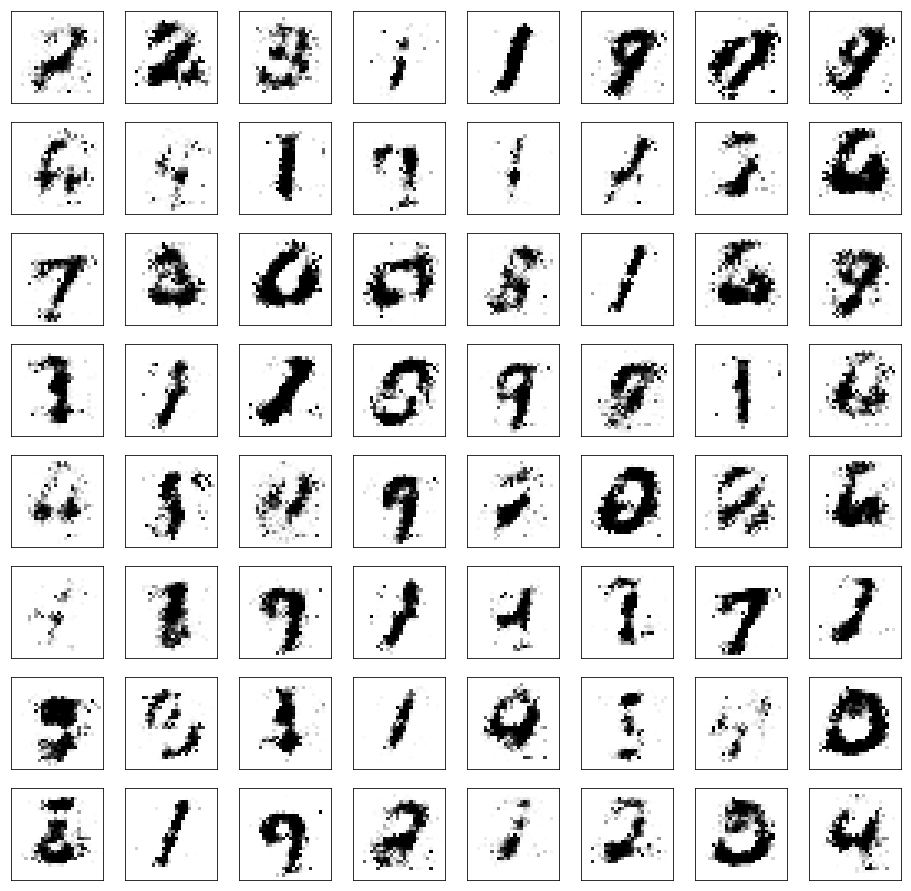

Epoch 81/400
 - 42s - d_loss: 0.5696 - g_loss: 2.2166
Epoch 82/400
 - 43s - d_loss: 0.6192 - g_loss: 2.5518
Epoch 83/400
 - 42s - d_loss: 0.6149 - g_loss: 2.0036
Epoch 84/400
 - 42s - d_loss: 0.5909 - g_loss: 2.5621
Epoch 85/400
 - 42s - d_loss: 0.6149 - g_loss: 2.1785
Epoch 86/400
 - 42s - d_loss: 0.5953 - g_loss: 2.5286
Epoch 87/400
 - 42s - d_loss: 0.6196 - g_loss: 2.3033
Epoch 88/400
 - 42s - d_loss: 0.6005 - g_loss: 2.3834
Epoch 89/400
 - 42s - d_loss: 0.6181 - g_loss: 1.9206
Epoch 90/400
 - 42s - d_loss: 0.6399 - g_loss: 2.5059
Epoch 91/400
 - 42s - d_loss: 0.5737 - g_loss: 2.3639
Epoch 92/400
 - 43s - d_loss: 0.6350 - g_loss: 2.4157
Epoch 93/400
 - 43s - d_loss: 0.6042 - g_loss: 2.2206
Epoch 94/400
 - 42s - d_loss: 0.6441 - g_loss: 1.9087
Epoch 95/400
 - 43s - d_loss: 0.5943 - g_loss: 2.8753
Epoch 96/400
 - 42s - d_loss: 0.6310 - g_loss: 1.6856
Epoch 97/400
 - 42s - d_loss: 0.6370 - g_loss: 2.5656
Epoch 98/400
 - 42s - d_loss: 0.6056 - g_loss: 1.9808
Epoch 99/400
 - 42s - d_loss

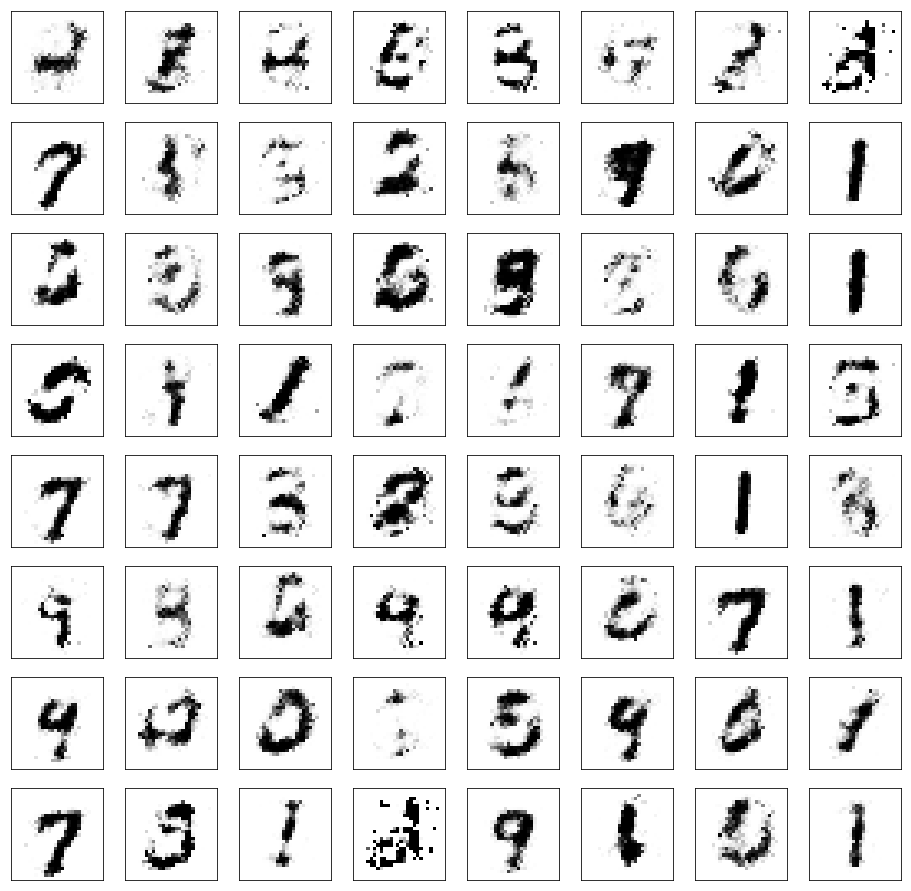

Epoch 101/400
 - 43s - d_loss: 0.6610 - g_loss: 1.9074
Epoch 102/400
 - 42s - d_loss: 0.6129 - g_loss: 2.3510
Epoch 103/400
 - 44s - d_loss: 0.6513 - g_loss: 2.1585
Epoch 104/400
 - 42s - d_loss: 0.6169 - g_loss: 2.2704
Epoch 105/400
 - 43s - d_loss: 0.6405 - g_loss: 2.0172
Epoch 106/400
 - 43s - d_loss: 0.6495 - g_loss: 2.1497
Epoch 107/400
 - 42s - d_loss: 0.6356 - g_loss: 2.4955
Epoch 108/400
 - 43s - d_loss: 0.6290 - g_loss: 1.7275
Epoch 109/400
 - 43s - d_loss: 0.6892 - g_loss: 2.3813
Epoch 110/400
 - 42s - d_loss: 0.5481 - g_loss: 2.6140
Epoch 111/400
 - 45s - d_loss: 0.6837 - g_loss: 1.7309
Epoch 112/400
 - 42s - d_loss: 0.6364 - g_loss: 2.0839
Epoch 113/400
 - 43s - d_loss: 0.6628 - g_loss: 2.4185
Epoch 114/400
 - 43s - d_loss: 0.5909 - g_loss: 2.0108
Epoch 115/400
 - 43s - d_loss: 0.7007 - g_loss: 1.9657
Epoch 116/400
 - 43s - d_loss: 0.5666 - g_loss: 2.8712
Epoch 117/400
 - 42s - d_loss: 0.6703 - g_loss: 1.2297
Epoch 118/400
 - 42s - d_loss: 0.6183 - g_loss: 3.2929
Epoch 119/

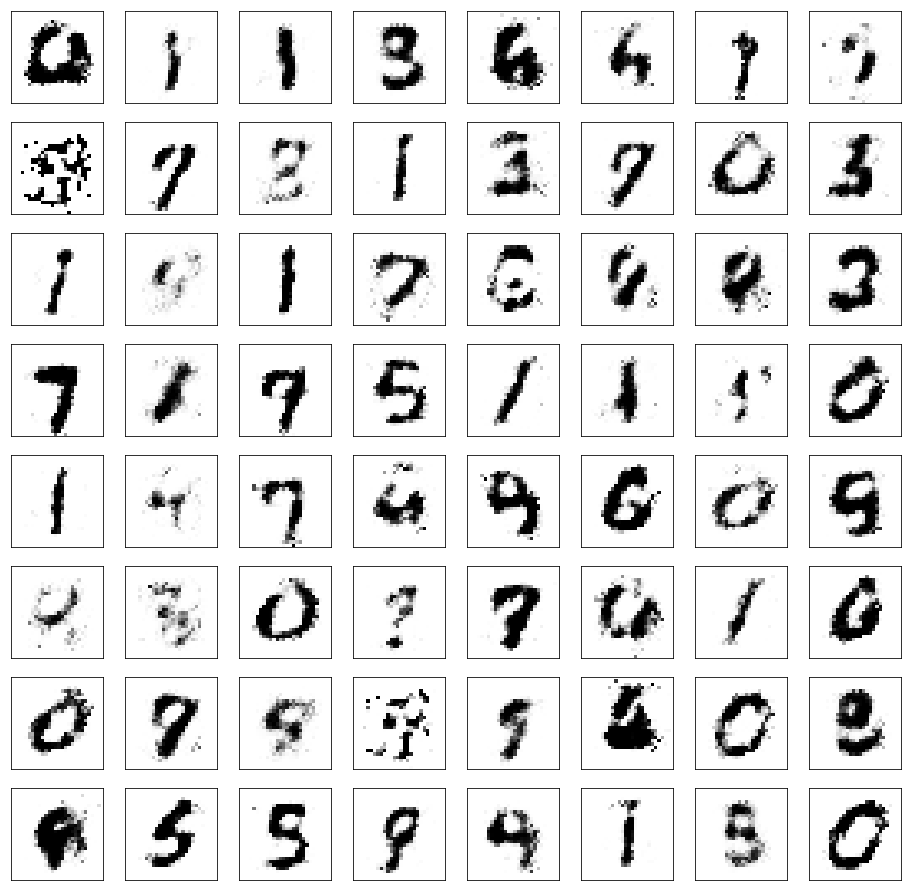

Epoch 121/400
 - 43s - d_loss: 0.6499 - g_loss: 1.3339
Epoch 122/400
 - 42s - d_loss: 0.6289 - g_loss: 3.0475
Epoch 123/400
 - 42s - d_loss: 0.6637 - g_loss: 1.2832
Epoch 124/400
 - 43s - d_loss: 0.5866 - g_loss: 3.8550
Epoch 125/400
 - 42s - d_loss: 0.6520 - g_loss: 1.4700
Epoch 126/400
 - 42s - d_loss: 0.6041 - g_loss: 2.8622
Epoch 127/400
 - 42s - d_loss: 0.6710 - g_loss: 1.4070
Epoch 128/400
 - 43s - d_loss: 0.6301 - g_loss: 2.9232
Epoch 129/400
 - 43s - d_loss: 0.6554 - g_loss: 1.2723
Epoch 130/400
 - 41s - d_loss: 0.5979 - g_loss: 3.7415
Epoch 131/400
 - 44s - d_loss: 0.6493 - g_loss: 1.4453
Epoch 132/400
 - 42s - d_loss: 0.5978 - g_loss: 3.3031
Epoch 133/400
 - 42s - d_loss: 0.6672 - g_loss: 1.2943
Epoch 134/400
 - 43s - d_loss: 0.6320 - g_loss: 2.7921
Epoch 135/400
 - 43s - d_loss: 0.6635 - g_loss: 1.3197
Epoch 136/400
 - 42s - d_loss: 0.6012 - g_loss: 3.6395
Epoch 137/400
 - 42s - d_loss: 0.6235 - g_loss: 1.2974
Epoch 138/400
 - 42s - d_loss: 0.6705 - g_loss: 3.1468
Epoch 139/

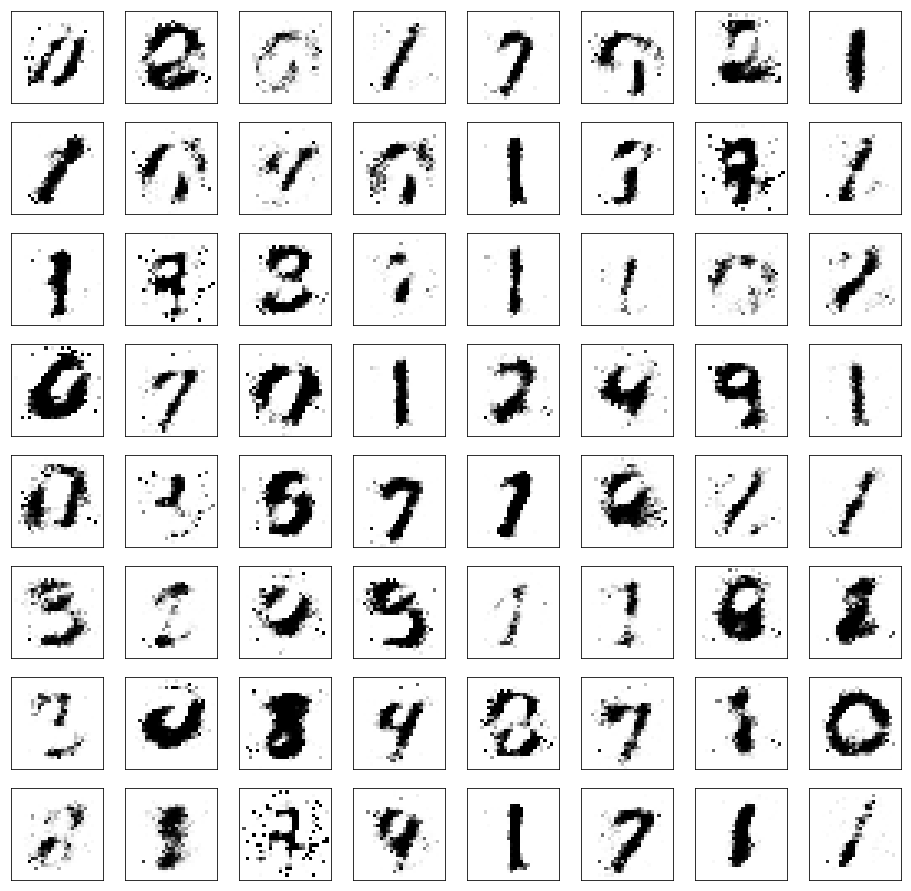

Epoch 141/400
 - 43s - d_loss: 0.6118 - g_loss: 1.5768
Epoch 142/400
 - 43s - d_loss: 0.6979 - g_loss: 2.9951
Epoch 143/400
 - 42s - d_loss: 0.5471 - g_loss: 2.1356
Epoch 144/400
 - 42s - d_loss: 0.7198 - g_loss: 1.8318
Epoch 145/400
 - 42s - d_loss: 0.5465 - g_loss: 2.9418
Epoch 146/400
 - 43s - d_loss: 0.7017 - g_loss: 1.1747
Epoch 147/400
 - 42s - d_loss: 0.6145 - g_loss: 2.8084
Epoch 148/400
 - 42s - d_loss: 0.6938 - g_loss: 1.2152
Epoch 149/400
 - 44s - d_loss: 0.5596 - g_loss: 3.9521
Epoch 150/400
 - 42s - d_loss: 0.6597 - g_loss: 1.1746
Epoch 151/400
 - 42s - d_loss: 0.6442 - g_loss: 2.6618
Epoch 152/400
 - 43s - d_loss: 0.6733 - g_loss: 1.1967
Epoch 153/400
 - 43s - d_loss: 0.6169 - g_loss: 3.3998
Epoch 154/400
 - 42s - d_loss: 0.6491 - g_loss: 1.2021
Epoch 155/400
 - 43s - d_loss: 0.6778 - g_loss: 2.6915
Epoch 156/400
 - 42s - d_loss: 0.6407 - g_loss: 1.3216
Epoch 157/400
 - 42s - d_loss: 0.7001 - g_loss: 3.3063
Epoch 158/400
 - 43s - d_loss: 0.5510 - g_loss: 1.9118
Epoch 159/

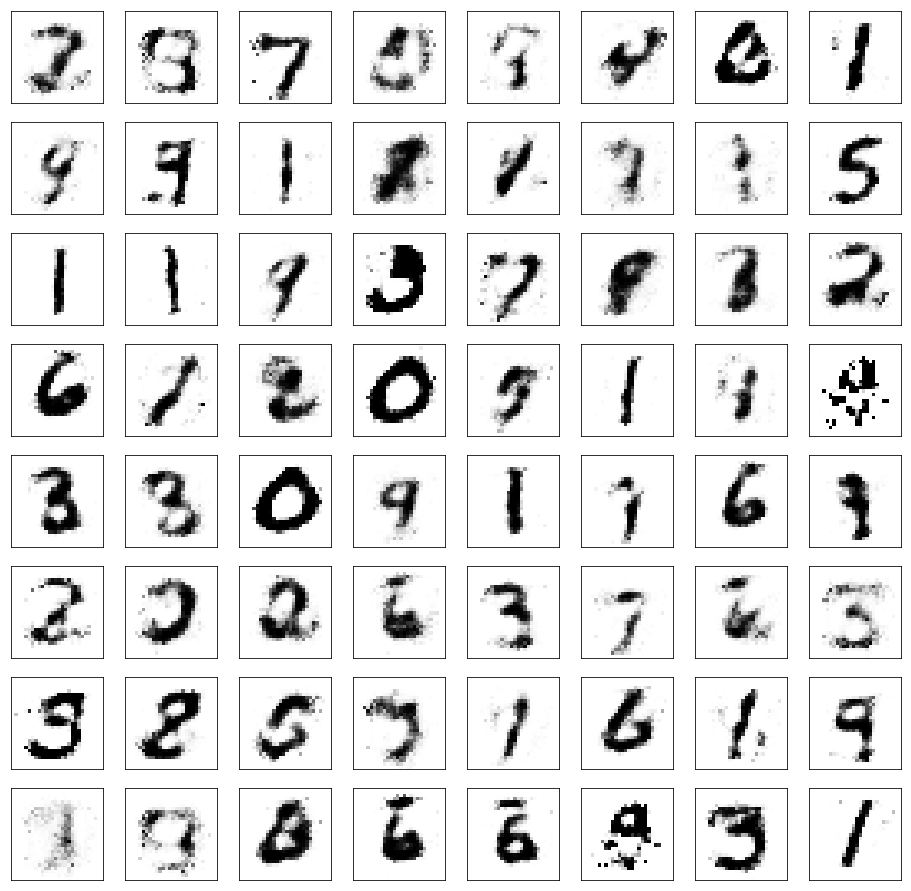

Epoch 161/400
 - 42s - d_loss: 0.7201 - g_loss: 2.3343
Epoch 162/400
 - 44s - d_loss: 0.6209 - g_loss: 1.7182
Epoch 163/400
 - 42s - d_loss: 0.7165 - g_loss: 2.3288
Epoch 164/400
 - 44s - d_loss: 0.5985 - g_loss: 1.9118
Epoch 165/400
 - 42s - d_loss: 0.7204 - g_loss: 2.8414
Epoch 166/400
 - 42s - d_loss: 0.5130 - g_loss: 2.3425
Epoch 167/400
 - 42s - d_loss: 0.7348 - g_loss: 1.7612
Epoch 168/400
 - 43s - d_loss: 0.5387 - g_loss: 3.0298
Epoch 169/400
 - 42s - d_loss: 0.7003 - g_loss: 1.2619
Epoch 170/400
 - 42s - d_loss: 0.6419 - g_loss: 2.9224
Epoch 171/400
 - 42s - d_loss: 0.6670 - g_loss: 1.1257
Epoch 172/400
 - 43s - d_loss: 0.6794 - g_loss: 2.8395
Epoch 173/400
 - 42s - d_loss: 0.6435 - g_loss: 1.3567
Epoch 174/400
 - 42s - d_loss: 0.7202 - g_loss: 3.0164
Epoch 175/400
 - 44s - d_loss: 0.5708 - g_loss: 1.7717
Epoch 176/400
 - 43s - d_loss: 0.7263 - g_loss: 2.1855
Epoch 177/400
 - 43s - d_loss: 0.5957 - g_loss: 2.1478
Epoch 178/400
 - 42s - d_loss: 0.7271 - g_loss: 1.4288
Epoch 179/

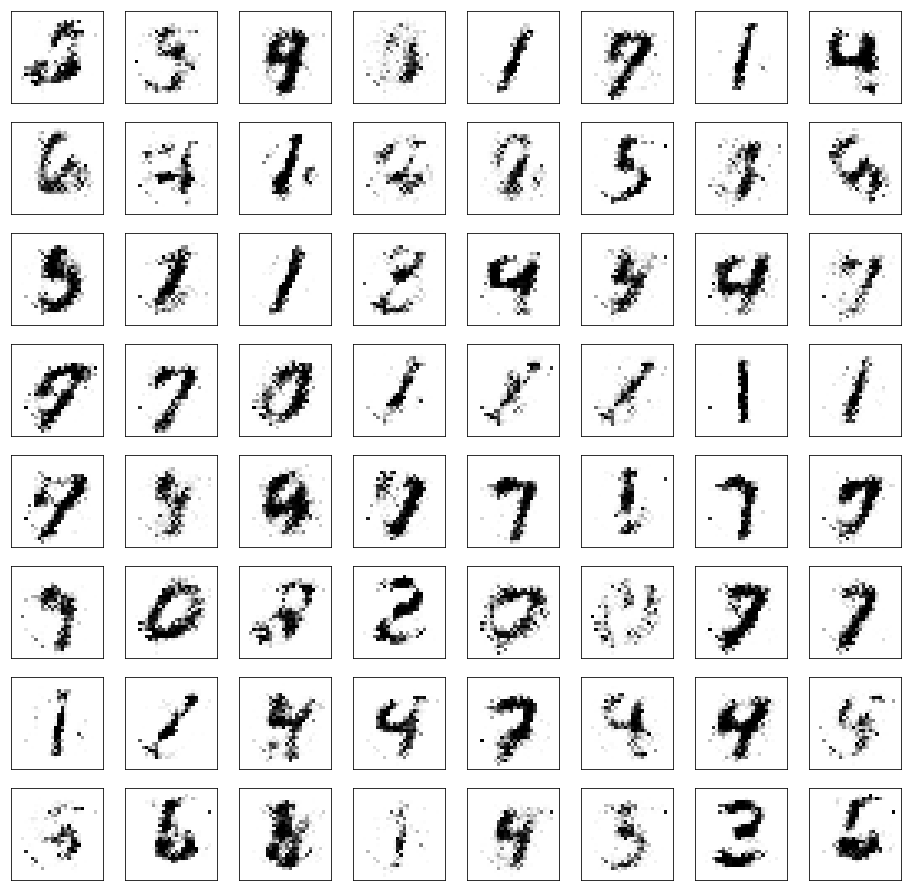

Epoch 181/400
 - 43s - d_loss: 0.5956 - g_loss: 2.8167
Epoch 182/400
 - 42s - d_loss: 0.7013 - g_loss: 1.1127
Epoch 183/400
 - 44s - d_loss: 0.6002 - g_loss: 3.5322
Epoch 184/400
 - 42s - d_loss: 0.6703 - g_loss: 1.0340
Epoch 185/400
 - 42s - d_loss: 0.6531 - g_loss: 3.2875
Epoch 186/400
 - 42s - d_loss: 0.6633 - g_loss: 1.1598
Epoch 187/400
 - 42s - d_loss: 0.6635 - g_loss: 2.8190
Epoch 188/400
 - 43s - d_loss: 0.6684 - g_loss: 1.0776
Epoch 189/400
 - 42s - d_loss: 0.6613 - g_loss: 3.4033
Epoch 190/400
 - 42s - d_loss: 0.6316 - g_loss: 1.1913
Epoch 191/400
 - 42s - d_loss: 0.6949 - g_loss: 2.6186
Epoch 192/400
 - 43s - d_loss: 0.6488 - g_loss: 1.2475
Epoch 193/400
 - 45s - d_loss: 0.7116 - g_loss: 2.6455
Epoch 194/400
 - 44s - d_loss: 0.6265 - g_loss: 1.3826
Epoch 195/400
 - 42s - d_loss: 0.7167 - g_loss: 2.2086
Epoch 196/400
 - 42s - d_loss: 0.6679 - g_loss: 1.3208
Epoch 197/400
 - 42s - d_loss: 0.7277 - g_loss: 2.6083
Epoch 198/400
 - 44s - d_loss: 0.6125 - g_loss: 1.5808
Epoch 199/

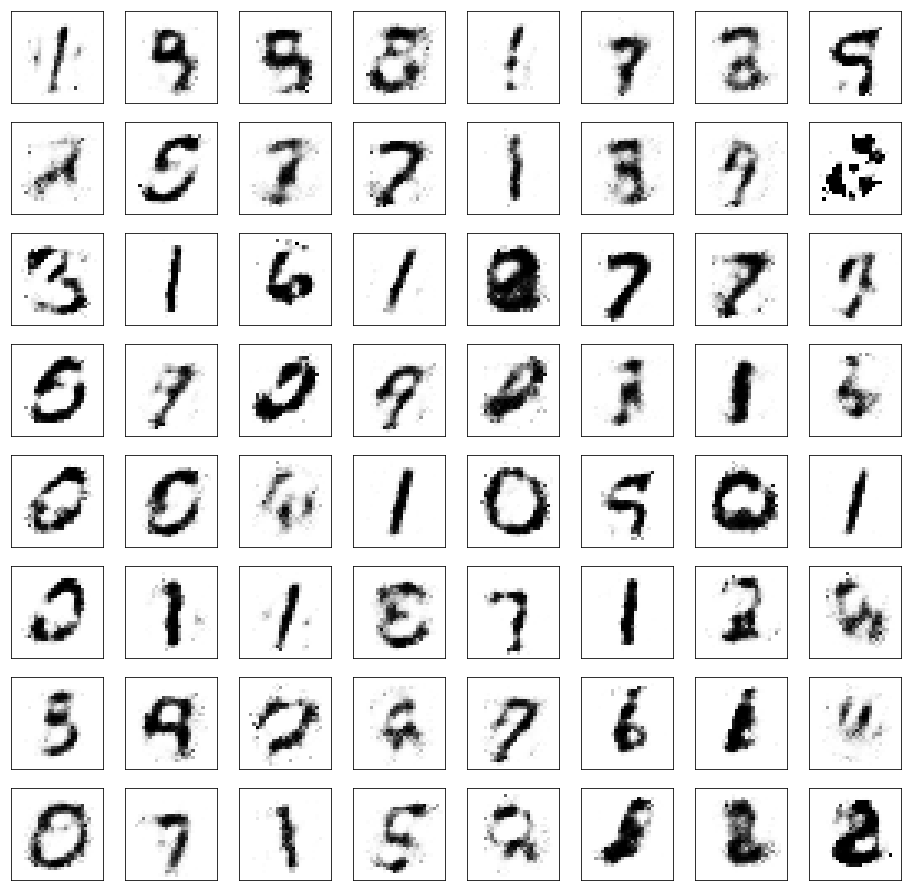

Epoch 201/400
 - 42s - d_loss: 0.6791 - g_loss: 3.3887
Epoch 202/400
 - 42s - d_loss: 0.5798 - g_loss: 1.6194
Epoch 203/400
 - 42s - d_loss: 0.7430 - g_loss: 1.7695
Epoch 204/400
 - 44s - d_loss: 0.6020 - g_loss: 2.0139
Epoch 205/400
 - 44s - d_loss: 0.7406 - g_loss: 1.9151
Epoch 206/400
 - 42s - d_loss: 0.6047 - g_loss: 2.0425
Epoch 207/400
 - 44s - d_loss: 0.7298 - g_loss: 1.9259
Epoch 208/400
 - 42s - d_loss: 0.6440 - g_loss: 1.6038
Epoch 209/400
 - 42s - d_loss: 0.7463 - g_loss: 2.1545
Epoch 210/400
 - 43s - d_loss: 0.6117 - g_loss: 1.9691
Epoch 211/400
 - 43s - d_loss: 0.7350 - g_loss: 1.3852
Epoch 212/400
 - 43s - d_loss: 0.5709 - g_loss: 3.0779
Epoch 213/400
 - 42s - d_loss: 0.7012 - g_loss: 1.2257
Epoch 214/400
 - 42s - d_loss: 0.6750 - g_loss: 2.3751
Epoch 215/400
 - 42s - d_loss: 0.7027 - g_loss: 1.2238
Epoch 216/400
 - 42s - d_loss: 0.6696 - g_loss: 2.5609
Epoch 217/400
 - 42s - d_loss: 0.6924 - g_loss: 1.1017
Epoch 218/400
 - 42s - d_loss: 0.7182 - g_loss: 2.3549
Epoch 219/

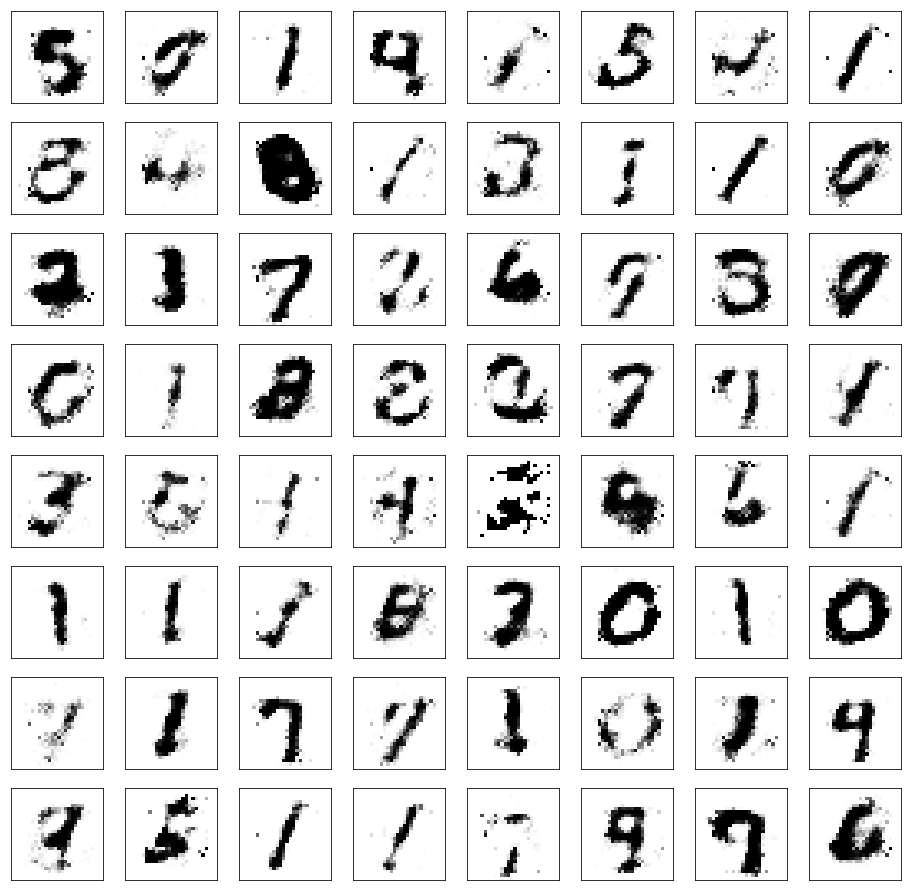

Epoch 221/400
 - 43s - d_loss: 0.6733 - g_loss: 1.1617
Epoch 222/400
 - 42s - d_loss: 0.6766 - g_loss: 2.9175
Epoch 223/400
 - 42s - d_loss: 0.6673 - g_loss: 1.0688
Epoch 224/400
 - 42s - d_loss: 0.6825 - g_loss: 2.9287
Epoch 225/400
 - 43s - d_loss: 0.6701 - g_loss: 1.0894
Epoch 226/400
 - 42s - d_loss: 0.6897 - g_loss: 2.5028
Epoch 227/400
 - 42s - d_loss: 0.6857 - g_loss: 1.1582
Epoch 228/400
 - 42s - d_loss: 0.7024 - g_loss: 2.7562
Epoch 229/400
 - 42s - d_loss: 0.6629 - g_loss: 1.1987
Epoch 230/400
 - 42s - d_loss: 0.7343 - g_loss: 2.0062
Epoch 231/400
 - 42s - d_loss: 0.6890 - g_loss: 1.3949
Epoch 232/400
 - 42s - d_loss: 0.7224 - g_loss: 2.9032
Epoch 233/400
 - 42s - d_loss: 0.6348 - g_loss: 1.2389
Epoch 234/400
 - 43s - d_loss: 0.7350 - g_loss: 2.2437
Epoch 235/400
 - 42s - d_loss: 0.6456 - g_loss: 1.3405
Epoch 236/400
 - 46s - d_loss: 0.7391 - g_loss: 1.9973
Epoch 237/400
 - 43s - d_loss: 0.6736 - g_loss: 1.3256
Epoch 238/400
 - 43s - d_loss: 0.7193 - g_loss: 2.9514
Epoch 239/

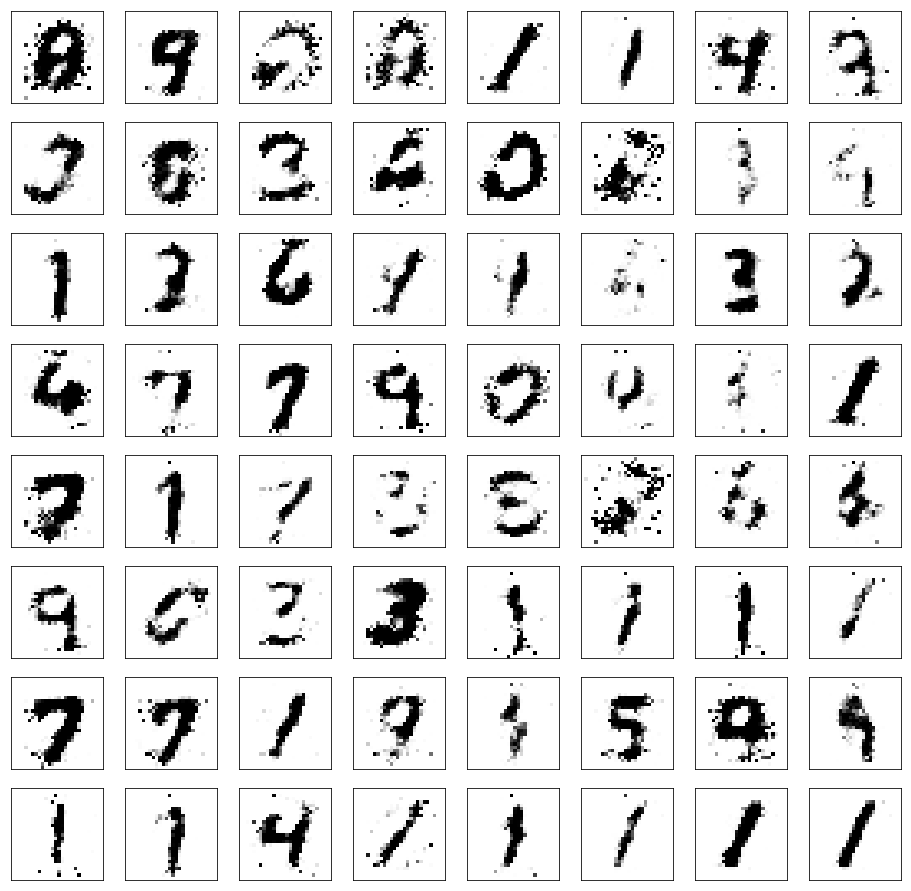

Epoch 241/400
 - 42s - d_loss: 0.5924 - g_loss: 1.4920
Epoch 242/400
 - 42s - d_loss: 0.7456 - g_loss: 1.8173
Epoch 243/400
 - 43s - d_loss: 0.6341 - g_loss: 1.7798
Epoch 244/400
 - 42s - d_loss: 0.7465 - g_loss: 1.8208
Epoch 245/400
 - 43s - d_loss: 0.6461 - g_loss: 1.7128
Epoch 246/400
 - 44s - d_loss: 0.7479 - g_loss: 2.2552
Epoch 247/400
 - 42s - d_loss: 0.6301 - g_loss: 1.4603
Epoch 248/400
 - 42s - d_loss: 0.7142 - g_loss: 2.4713
Epoch 249/400
 - 44s - d_loss: 0.6606 - g_loss: 1.0673
Epoch 250/400
 - 43s - d_loss: 0.7379 - g_loss: 2.4708
Epoch 251/400
 - 43s - d_loss: 0.6427 - g_loss: 1.3179
Epoch 252/400
 - 42s - d_loss: 0.7488 - g_loss: 1.8939
Epoch 253/400
 - 42s - d_loss: 0.6498 - g_loss: 2.0073
Epoch 254/400
 - 42s - d_loss: 0.7479 - g_loss: 1.4683
Epoch 255/400
 - 44s - d_loss: 0.6728 - g_loss: 1.8334
Epoch 256/400
 - 42s - d_loss: 0.7560 - g_loss: 1.7469
Epoch 257/400
 - 43s - d_loss: 0.6582 - g_loss: 1.7165
Epoch 258/400
 - 43s - d_loss: 0.7509 - g_loss: 1.7521
Epoch 259/

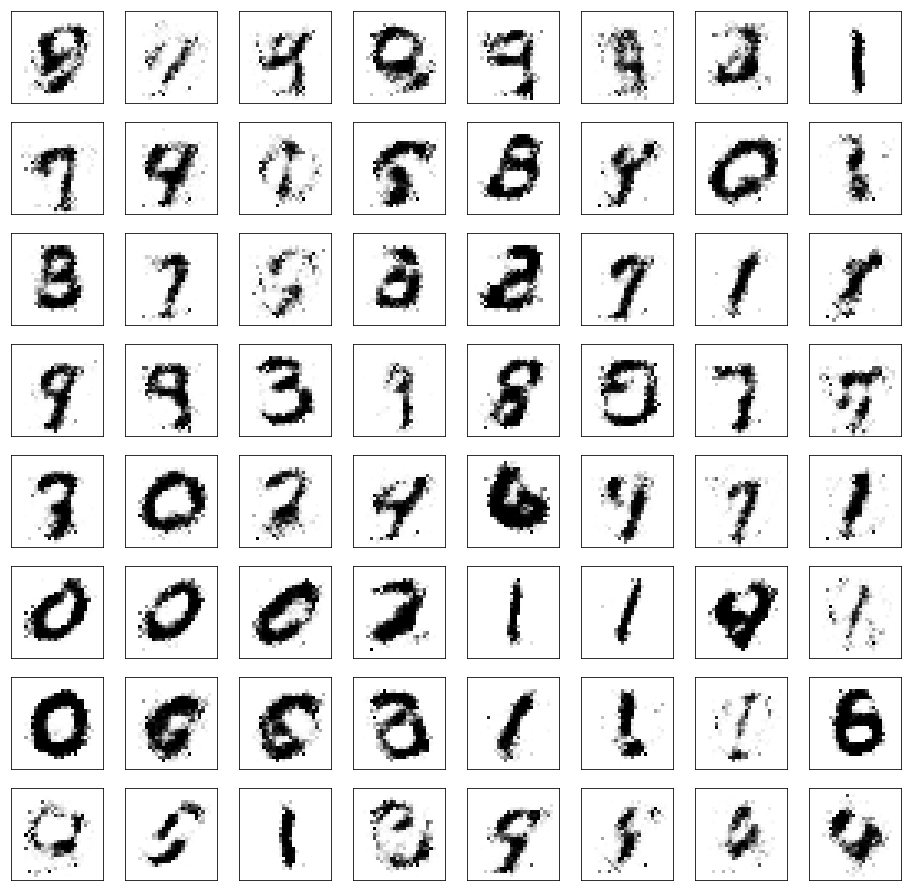

Epoch 261/400
 - 42s - d_loss: 0.6532 - g_loss: 2.3719
Epoch 262/400
 - 43s - d_loss: 0.7151 - g_loss: 1.1325
Epoch 263/400
 - 43s - d_loss: 0.6650 - g_loss: 2.6162
Epoch 264/400
 - 44s - d_loss: 0.6959 - g_loss: 1.0787
Epoch 265/400
 - 41s - d_loss: 0.7062 - g_loss: 2.3030
Epoch 266/400
 - 44s - d_loss: 0.6985 - g_loss: 1.1404
Epoch 267/400
 - 43s - d_loss: 0.7239 - g_loss: 2.2067
Epoch 268/400
 - 42s - d_loss: 0.6978 - g_loss: 1.2356
Epoch 269/400
 - 43s - d_loss: 0.6882 - g_loss: 2.6633
Epoch 270/400
 - 42s - d_loss: 0.6919 - g_loss: 1.0712
Epoch 271/400
 - 42s - d_loss: 0.7248 - g_loss: 2.1899
Epoch 272/400
 - 42s - d_loss: 0.7107 - g_loss: 1.2279
Epoch 273/400
 - 42s - d_loss: 0.6930 - g_loss: 2.2710
Epoch 274/400
 - 43s - d_loss: 0.7040 - g_loss: 1.0604
Epoch 275/400
 - 43s - d_loss: 0.6875 - g_loss: 2.4814
Epoch 276/400
 - 42s - d_loss: 0.6858 - g_loss: 1.0612
Epoch 277/400
 - 42s - d_loss: 0.7050 - g_loss: 2.9933
Epoch 278/400
 - 43s - d_loss: 0.6506 - g_loss: 1.1500
Epoch 279/

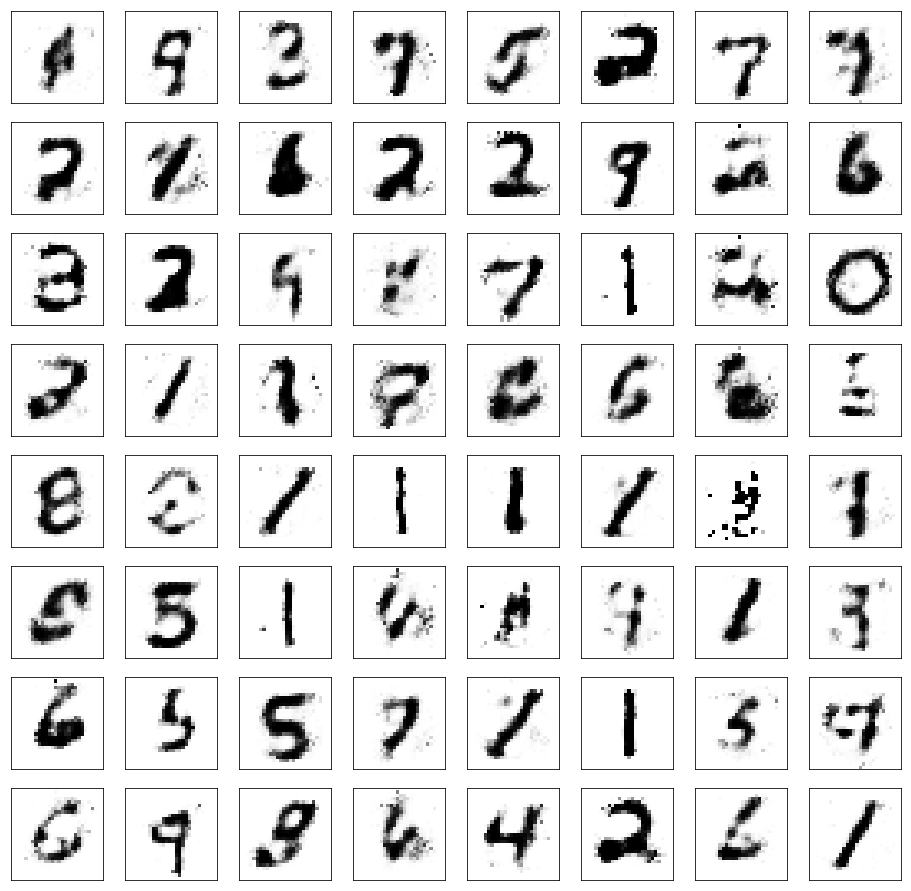

Epoch 281/400
 - 42s - d_loss: 0.7373 - g_loss: 2.1062
Epoch 282/400
 - 43s - d_loss: 0.6610 - g_loss: 1.2936
Epoch 283/400
 - 43s - d_loss: 0.7290 - g_loss: 2.4641
Epoch 284/400
 - 42s - d_loss: 0.6601 - g_loss: 1.1595
Epoch 285/400
 - 43s - d_loss: 0.7526 - g_loss: 2.2506
Epoch 286/400
 - 43s - d_loss: 0.6624 - g_loss: 1.1659
Epoch 287/400
 - 43s - d_loss: 0.7602 - g_loss: 2.4563
Epoch 288/400
 - 42s - d_loss: 0.6318 - g_loss: 1.4287
Epoch 289/400
 - 43s - d_loss: 0.7674 - g_loss: 2.0566
Epoch 290/400
 - 43s - d_loss: 0.6411 - g_loss: 1.3098
Epoch 291/400
 - 43s - d_loss: 0.7554 - g_loss: 1.9221
Epoch 292/400
 - 42s - d_loss: 0.6361 - g_loss: 1.6609
Epoch 293/400
 - 42s - d_loss: 0.7427 - g_loss: 2.1678
Epoch 294/400
 - 43s - d_loss: 0.6630 - g_loss: 1.2171
Epoch 295/400
 - 43s - d_loss: 0.7372 - g_loss: 1.9907
Epoch 296/400
 - 42s - d_loss: 0.6886 - g_loss: 1.1328
Epoch 297/400
 - 43s - d_loss: 0.6990 - g_loss: 2.7618
Epoch 298/400
 - 43s - d_loss: 0.6680 - g_loss: 0.9926
Epoch 299/

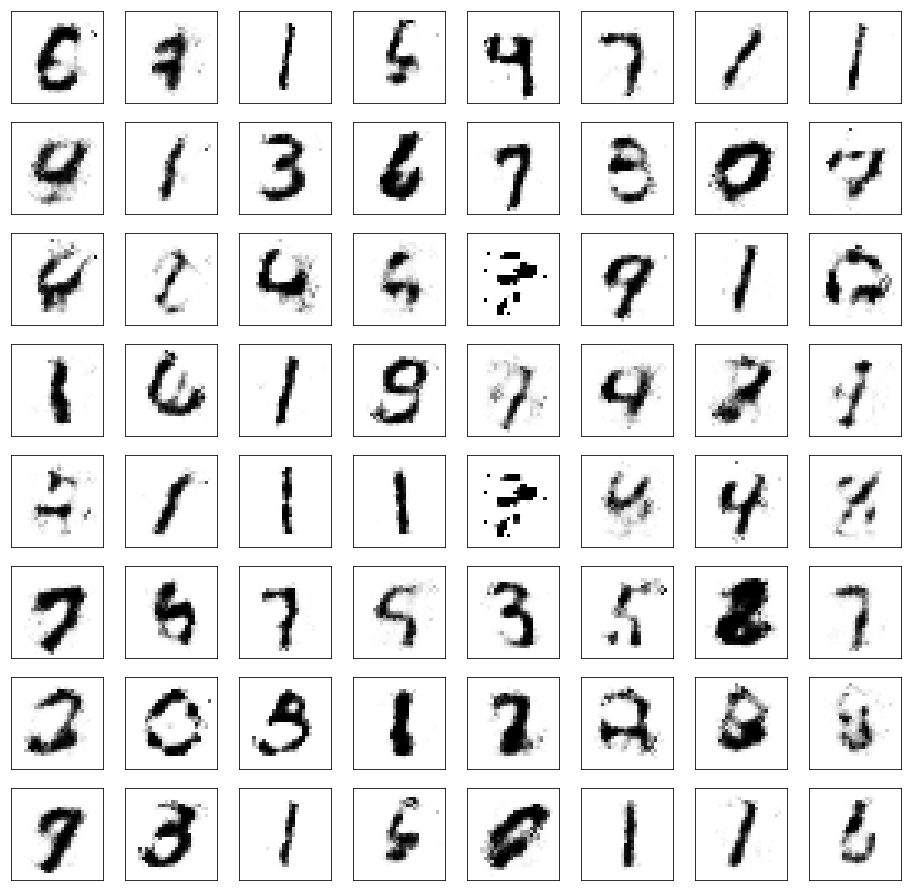

Epoch 301/400
 - 42s - d_loss: 0.7343 - g_loss: 2.7083
Epoch 302/400
 - 43s - d_loss: 0.6506 - g_loss: 1.1730
Epoch 303/400
 - 42s - d_loss: 0.7426 - g_loss: 2.4798
Epoch 304/400
 - 42s - d_loss: 0.6231 - g_loss: 1.3771
Epoch 305/400
 - 43s - d_loss: 0.7605 - g_loss: 2.0519
Epoch 306/400
 - 42s - d_loss: 0.6292 - g_loss: 1.5204
Epoch 307/400
 - 44s - d_loss: 0.7462 - g_loss: 2.0603
Epoch 308/400
 - 43s - d_loss: 0.6401 - g_loss: 1.4184
Epoch 309/400
 - 43s - d_loss: 0.7635 - g_loss: 2.2040
Epoch 310/400
 - 42s - d_loss: 0.6321 - g_loss: 1.4137
Epoch 311/400
 - 43s - d_loss: 0.7377 - g_loss: 2.4214
Epoch 312/400
 - 43s - d_loss: 0.6464 - g_loss: 1.1467
Epoch 313/400
 - 42s - d_loss: 0.7526 - g_loss: 1.7678
Epoch 314/400
 - 43s - d_loss: 0.6698 - g_loss: 1.5578
Epoch 315/400
 - 42s - d_loss: 0.7662 - g_loss: 2.3344
Epoch 316/400
 - 42s - d_loss: 0.6674 - g_loss: 1.1640
Epoch 317/400
 - 43s - d_loss: 0.7449 - g_loss: 2.2372
Epoch 318/400
 - 43s - d_loss: 0.6779 - g_loss: 1.1789
Epoch 319/

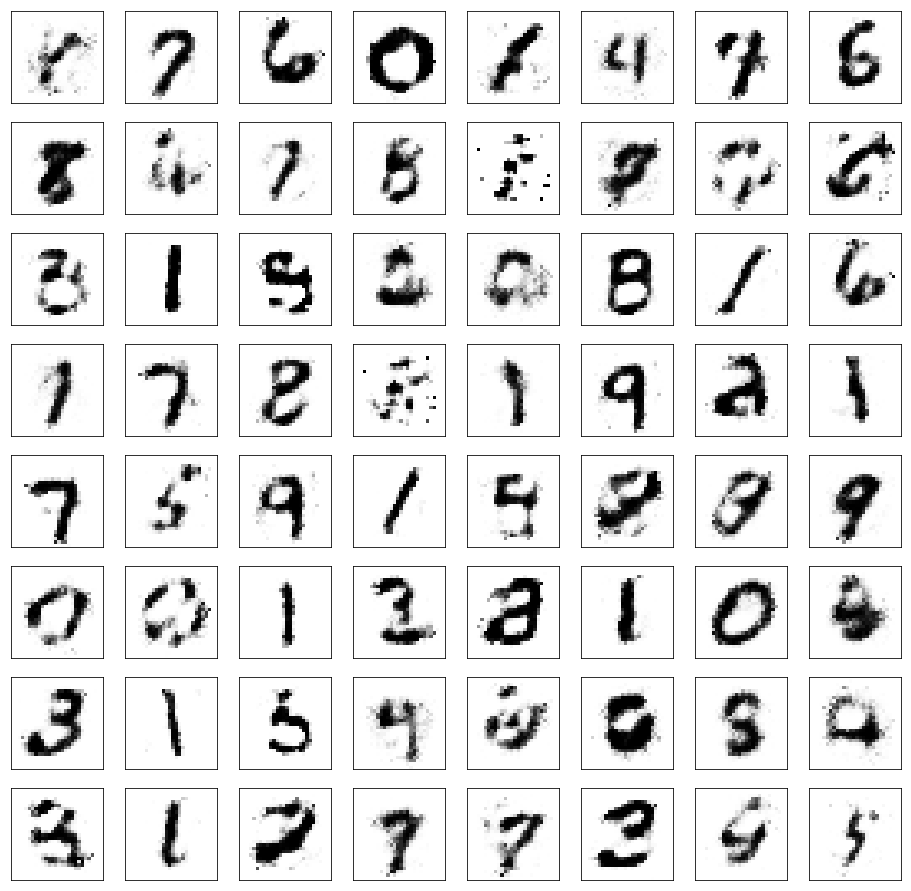

Epoch 321/400
 - 42s - d_loss: 0.7546 - g_loss: 2.4679
Epoch 322/400
 - 43s - d_loss: 0.6419 - g_loss: 1.1611
Epoch 323/400
 - 43s - d_loss: 0.7741 - g_loss: 1.8518
Epoch 324/400
 - 42s - d_loss: 0.6203 - g_loss: 1.7899
Epoch 325/400
 - 43s - d_loss: 0.7617 - g_loss: 1.7029
Epoch 326/400
 - 43s - d_loss: 0.6637 - g_loss: 1.4369
Epoch 327/400
 - 42s - d_loss: 0.7628 - g_loss: 2.0679
Epoch 328/400
 - 42s - d_loss: 0.6437 - g_loss: 1.5100
Epoch 329/400
 - 43s - d_loss: 0.7627 - g_loss: 1.7102
Epoch 330/400
 - 42s - d_loss: 0.6848 - g_loss: 1.5175
Epoch 331/400
 - 42s - d_loss: 0.7655 - g_loss: 1.6430
Epoch 332/400
 - 43s - d_loss: 0.6535 - g_loss: 1.9514
Epoch 333/400
 - 43s - d_loss: 0.7516 - g_loss: 1.4332
Epoch 334/400
 - 43s - d_loss: 0.6816 - g_loss: 1.9929
Epoch 335/400
 - 42s - d_loss: 0.7265 - g_loss: 1.1387
Epoch 336/400
 - 44s - d_loss: 0.7124 - g_loss: 2.2221
Epoch 337/400
 - 43s - d_loss: 0.7599 - g_loss: 1.6652
Epoch 338/400
 - 42s - d_loss: 0.6753 - g_loss: 1.3849
Epoch 339/

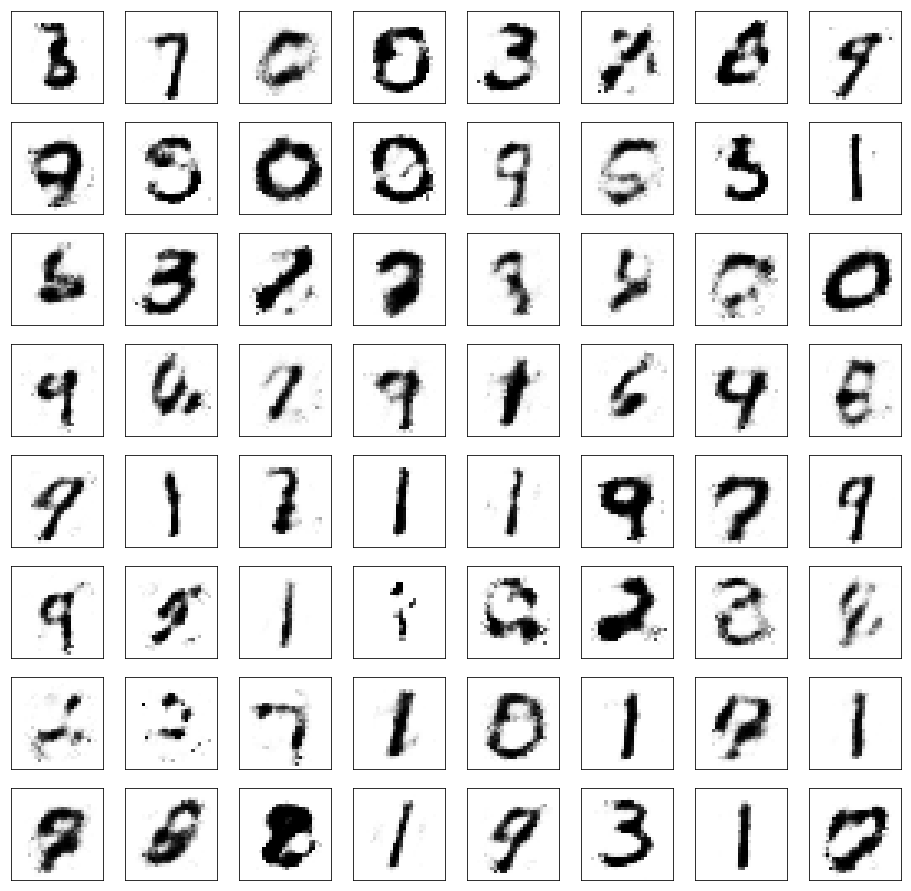

Epoch 341/400
 - 42s - d_loss: 0.7698 - g_loss: 2.1845
Epoch 342/400
 - 42s - d_loss: 0.6355 - g_loss: 1.4081
Epoch 343/400
 - 43s - d_loss: 0.7565 - g_loss: 2.1083
Epoch 344/400
 - 42s - d_loss: 0.6466 - g_loss: 1.3448
Epoch 345/400
 - 43s - d_loss: 0.7748 - g_loss: 2.1723
Epoch 346/400
 - 43s - d_loss: 0.6391 - g_loss: 1.4146
Epoch 347/400
 - 42s - d_loss: 0.7286 - g_loss: 1.1130
Epoch 348/400
 - 43s - d_loss: 0.6831 - g_loss: 2.7026
Epoch 349/400
 - 43s - d_loss: 0.7036 - g_loss: 1.0814
Epoch 350/400
 - 42s - d_loss: 0.7643 - g_loss: 2.0402
Epoch 351/400
 - 43s - d_loss: 0.7015 - g_loss: 1.3158
Epoch 352/400
 - 43s - d_loss: 0.7407 - g_loss: 1.7692
Epoch 353/400
 - 42s - d_loss: 0.7214 - g_loss: 1.0672
Epoch 354/400
 - 44s - d_loss: 0.7139 - g_loss: 2.4005
Epoch 355/400
 - 41s - d_loss: 0.7403 - g_loss: 1.3915
Epoch 356/400
 - 43s - d_loss: 0.6459 - g_loss: 2.2082
Epoch 357/400
 - 44s - d_loss: 0.7039 - g_loss: 1.0206
Epoch 358/400
 - 43s - d_loss: 0.7286 - g_loss: 2.5682
Epoch 359/

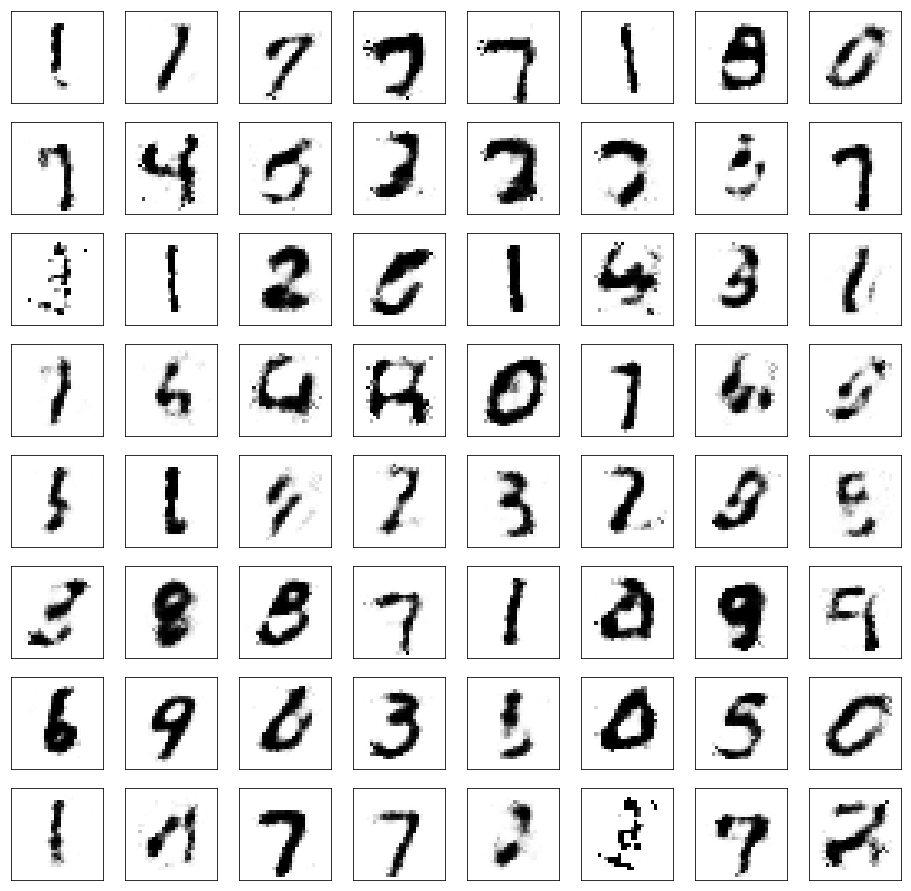

Epoch 361/400
 - 43s - d_loss: 0.6788 - g_loss: 0.9841
Epoch 362/400
 - 42s - d_loss: 0.7361 - g_loss: 2.2775
Epoch 363/400
 - 42s - d_loss: 0.6793 - g_loss: 1.0397
Epoch 364/400
 - 42s - d_loss: 0.7444 - g_loss: 2.2710
Epoch 365/400
 - 42s - d_loss: 0.6846 - g_loss: 1.0410
Epoch 366/400
 - 42s - d_loss: 0.7586 - g_loss: 2.1352
Epoch 367/400
 - 43s - d_loss: 0.6913 - g_loss: 1.1118
Epoch 368/400
 - 44s - d_loss: 0.7519 - g_loss: 2.1865
Epoch 369/400
 - 42s - d_loss: 0.6982 - g_loss: 1.1001
Epoch 370/400
 - 44s - d_loss: 0.7213 - g_loss: 2.2300
Epoch 371/400
 - 42s - d_loss: 0.7077 - g_loss: 1.0378
Epoch 372/400
 - 44s - d_loss: 0.7474 - g_loss: 2.0563
Epoch 373/400
 - 43s - d_loss: 0.7079 - g_loss: 1.0925
Epoch 374/400
 - 42s - d_loss: 0.7485 - g_loss: 2.0153
Epoch 375/400
 - 42s - d_loss: 0.7090 - g_loss: 1.1188
Epoch 376/400
 - 43s - d_loss: 0.6937 - g_loss: 2.4638
Epoch 377/400
 - 43s - d_loss: 0.7181 - g_loss: 1.0786
Epoch 378/400
 - 42s - d_loss: 0.6867 - g_loss: 2.2710
Epoch 379/

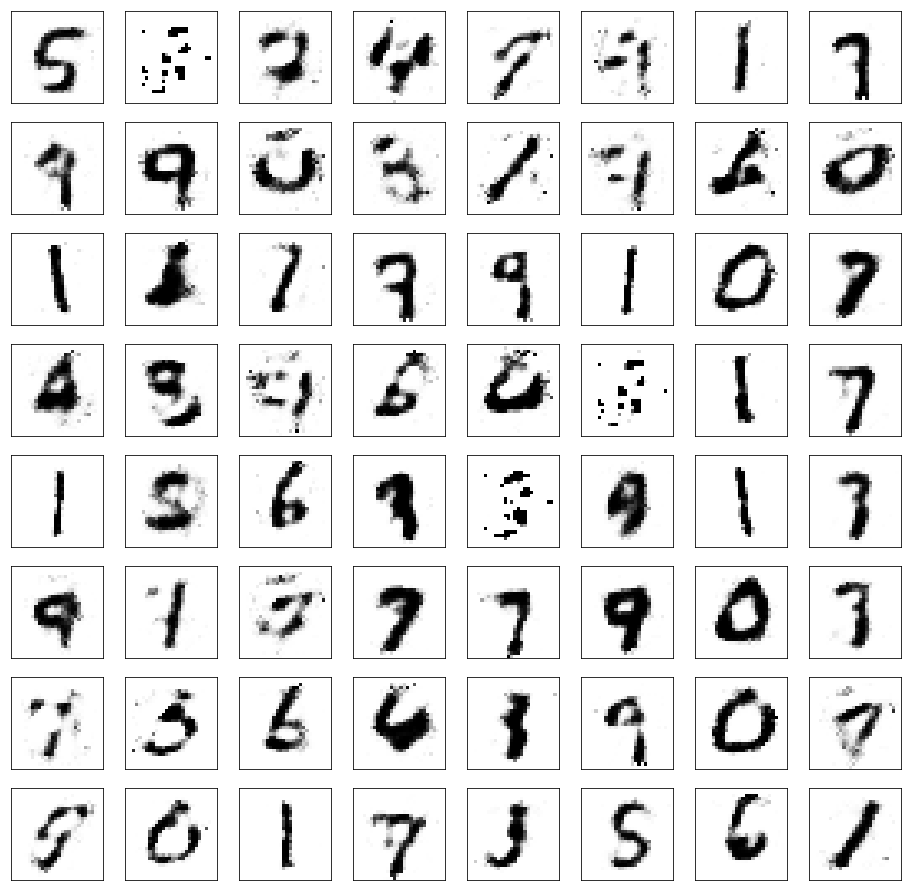

Epoch 381/400
 - 44s - d_loss: 0.7429 - g_loss: 1.2310
Epoch 382/400
 - 43s - d_loss: 0.6867 - g_loss: 2.0789
Epoch 383/400
 - 42s - d_loss: 0.7349 - g_loss: 1.2587
Epoch 384/400
 - 42s - d_loss: 0.6998 - g_loss: 1.8815
Epoch 385/400
 - 44s - d_loss: 0.7602 - g_loss: 1.3532
Epoch 386/400
 - 42s - d_loss: 0.6773 - g_loss: 1.9434
Epoch 387/400
 - 43s - d_loss: 0.7734 - g_loss: 1.4804
Epoch 388/400
 - 43s - d_loss: 0.6399 - g_loss: 1.8660
Epoch 389/400
 - 42s - d_loss: 0.7512 - g_loss: 1.5880
Epoch 390/400
 - 43s - d_loss: 0.6831 - g_loss: 1.3703
Epoch 391/400
 - 42s - d_loss: 0.7651 - g_loss: 2.3322
Epoch 392/400
 - 43s - d_loss: 0.6639 - g_loss: 1.0900
Epoch 393/400
 - 42s - d_loss: 0.7578 - g_loss: 1.8982
Epoch 394/400
 - 42s - d_loss: 0.6939 - g_loss: 1.1246
Epoch 395/400
 - 43s - d_loss: 0.7386 - g_loss: 1.9903
Epoch 396/400
 - 44s - d_loss: 0.7314 - g_loss: 1.1501
Epoch 397/400
 - 42s - d_loss: 0.7358 - g_loss: 1.8799
Epoch 398/400
 - 42s - d_loss: 0.7359 - g_loss: 1.2612
Epoch 399/

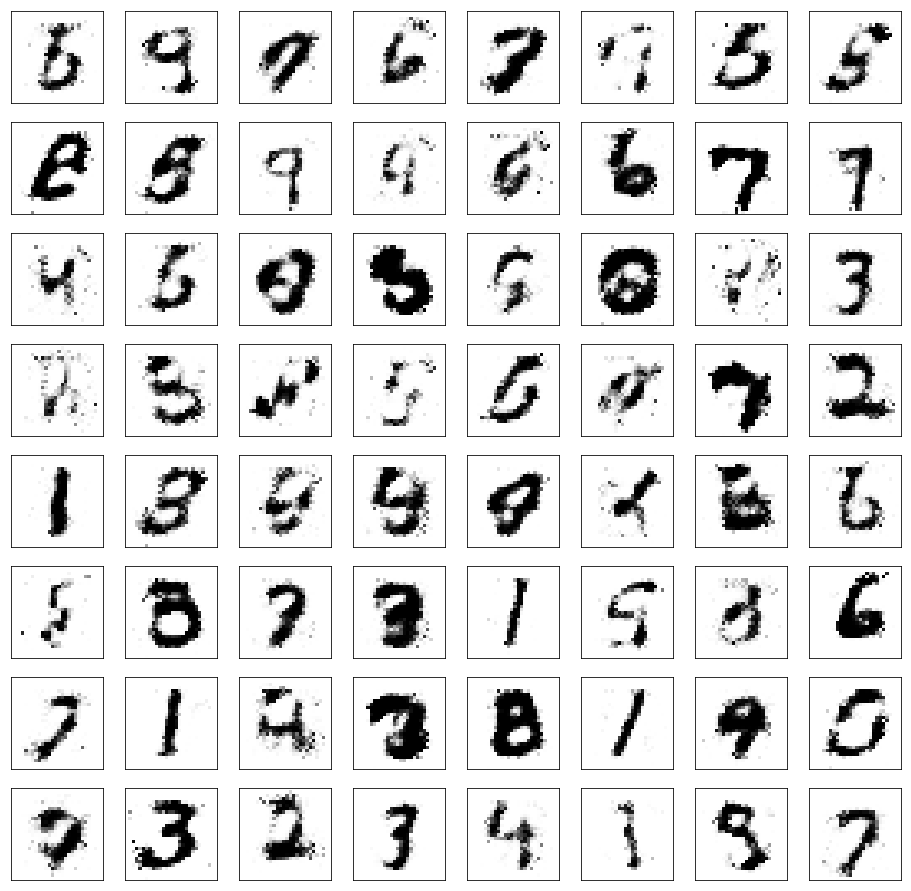

In [10]:
train(train_x, epochs=400, batch_size=128)